In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib inline

import itertools
from kernels import HMC_our, HMC_vanilla, Reverse_kernel_sampling
from target import GMM_target, GMM_target2, Funnel, Gaussian_target
from args import get_args

import matplotlib
matplotlib.rcParams.update({'font.size': 20})

import pdb

In [2]:
args = get_args()

In [3]:
target = GMM_target(args)

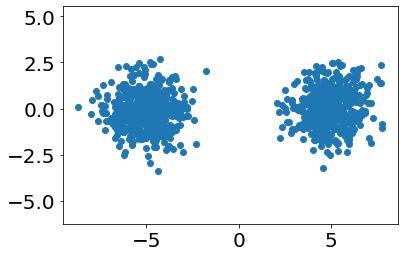

In [4]:
target_samples = target.get_samples(n=1000).cpu().numpy()
plt.scatter(target_samples[:, 0], target_samples[:, 1])
plt.axis('equal');

#### Common setup

In [5]:
args.n_steps = 1000 # how many samples to use
args.n_warmup = 1000 # num of first samples to refuse

args.n_chains = 10 # how many chains to model

In [6]:
q_init = args.std_normal.sample((args.n_chains, args.z_dim))
p_init = args.std_normal.sample((args.n_chains, args.z_dim))

#### Vanilla HMC

In [7]:
vanilla_kernel = HMC_vanilla(args)

In [8]:
q_new = q_init
p_new = p_init

print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()
    
samples_vanilla = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)
print("Now we are sampling!")

iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
    samples_vanilla[i] = q_new
iterator.close()

  2%|▏         | 24/1000 [00:00<00:04, 233.78it/s]

Now we are running warmup!


  2%|▎         | 25/1000 [00:00<00:03, 244.13it/s]

Now we are sampling!


100%|██████████| 1000/1000 [00:04<00:00, 242.09it/s]


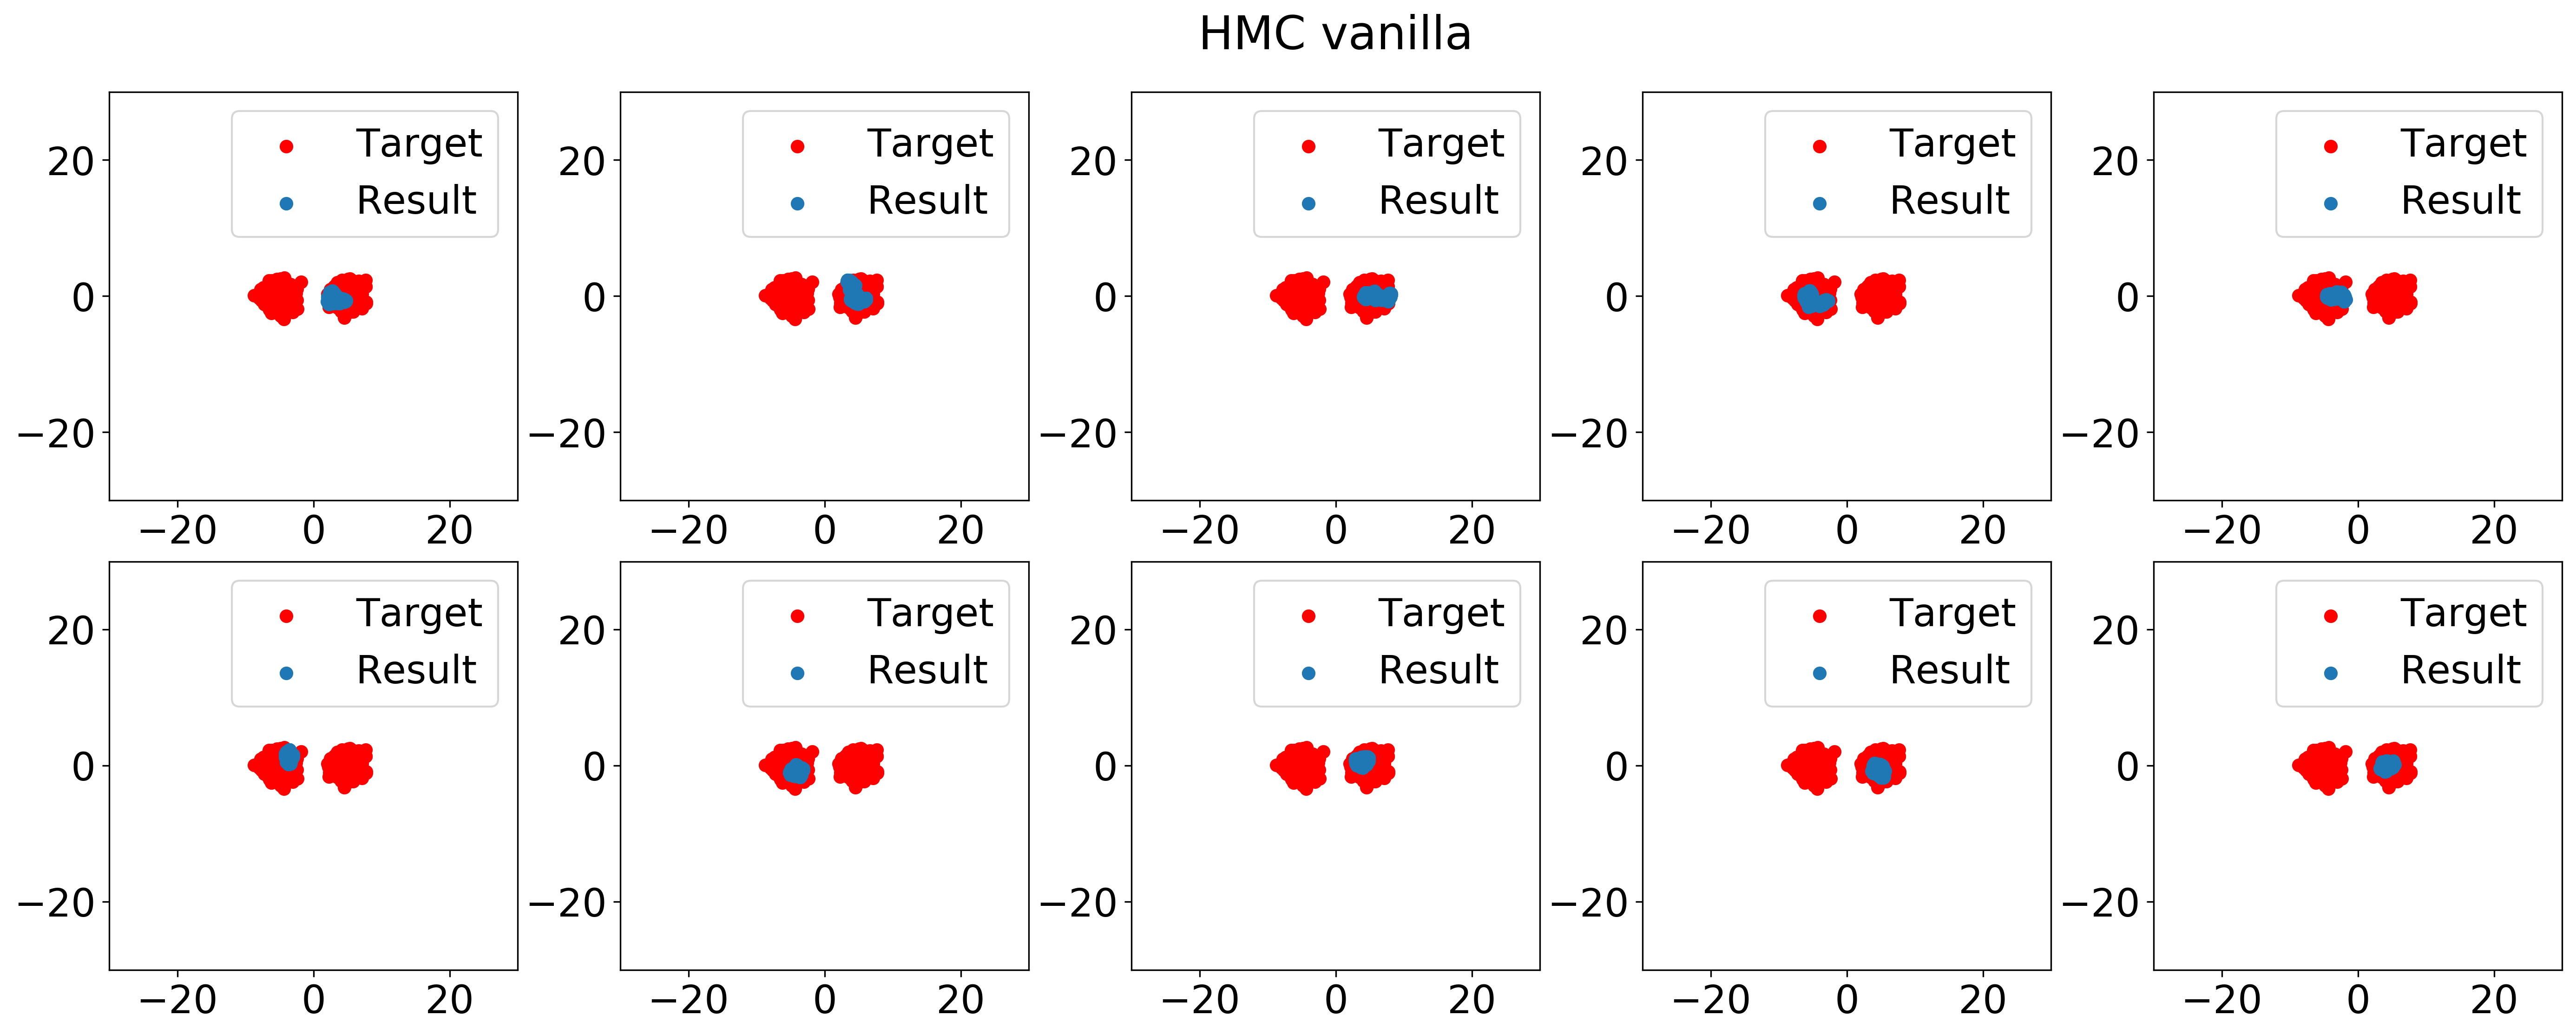

In [9]:
limit = 30
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('HMC vanilla')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_vanilla[:, chain_num, 0].cpu(), samples_vanilla[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

#### Ours HMC

In [10]:
if args.learnable_reverse:
    reverse_kernel = Reverse_kernel_sampling(kwargs=args).to(args.device)
    reverse_params = reverse_kernel.parameters()
else:
    reverse_params = list([])
    
transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args.K)])
our_kernel = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args.K)])

params = [transitions.parameters(), reverse_params]

optimizer = torch.optim.Adam(params=itertools.chain(*params))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=200, factor=0.9)

##### Training

  0%|          | 0/10000 [00:00<?, ?it/s]

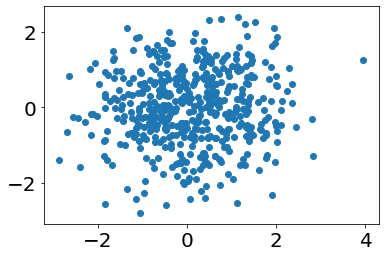

  0%|          | 3/10000 [00:00<26:56,  6.18it/s]

Current lr:  0.001
On batch number 0 ELBO is -22.48198127746582
On batch number 0 Best ELBO is -inf


  1%|          | 99/10000 [00:06<10:57, 15.06it/s]

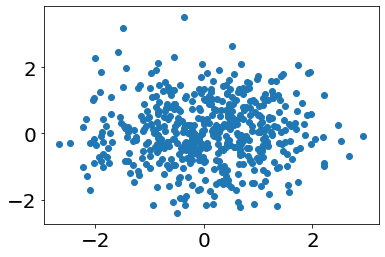

  1%|          | 103/10000 [00:07<13:47, 11.96it/s]

Current lr:  0.001
On batch number 100 ELBO is -21.65213394165039
On batch number 100 Best ELBO is -20.93968391418457


  2%|▏         | 199/10000 [00:13<10:46, 15.16it/s]

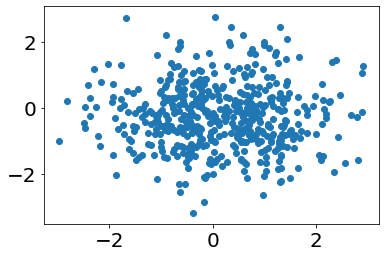

  2%|▏         | 201/10000 [00:13<14:04, 11.60it/s]

Current lr:  0.001
On batch number 200 ELBO is -20.383752822875977
On batch number 200 Best ELBO is -20.300556182861328


  3%|▎         | 299/10000 [00:20<10:40, 15.15it/s]

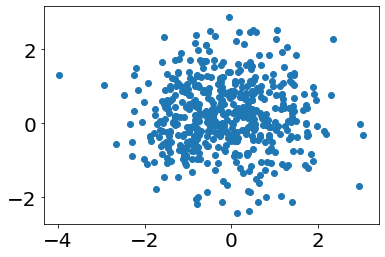

  3%|▎         | 303/10000 [00:20<12:57, 12.47it/s]

Current lr:  0.001
On batch number 300 ELBO is -20.291574478149414
On batch number 300 Best ELBO is -19.371244430541992


  4%|▍         | 399/10000 [00:27<10:33, 15.16it/s]

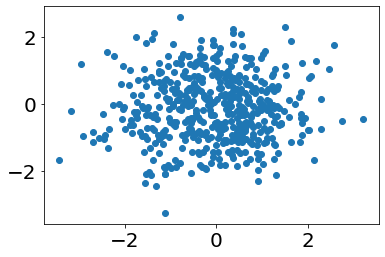

  4%|▍         | 401/10000 [00:27<14:41, 10.89it/s]

Current lr:  0.001
On batch number 400 ELBO is -18.968767166137695
On batch number 400 Best ELBO is -18.606534957885742


  5%|▍         | 499/10000 [00:33<10:29, 15.10it/s]

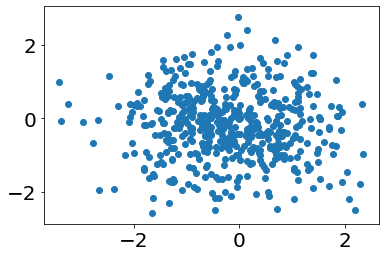

  5%|▌         | 501/10000 [00:34<13:33, 11.68it/s]

Current lr:  0.001
On batch number 500 ELBO is -18.131296157836914
On batch number 500 Best ELBO is -17.616100311279297


  6%|▌         | 599/10000 [00:40<10:16, 15.25it/s]

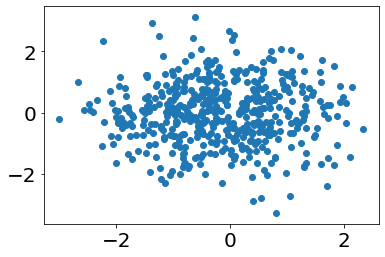

  6%|▌         | 601/10000 [00:40<13:18, 11.78it/s]

Current lr:  0.001
On batch number 600 ELBO is -17.59394645690918
On batch number 600 Best ELBO is -17.119449615478516


  7%|▋         | 699/10000 [00:47<10:03, 15.40it/s]

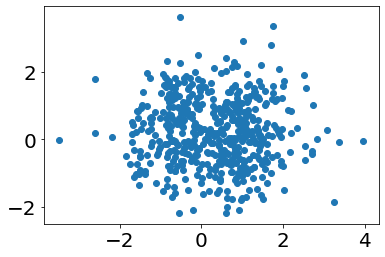

  7%|▋         | 701/10000 [00:47<13:08, 11.79it/s]

Current lr:  0.001
On batch number 700 ELBO is -16.84037971496582
On batch number 700 Best ELBO is -16.515438079833984


  8%|▊         | 799/10000 [00:53<10:00, 15.33it/s]

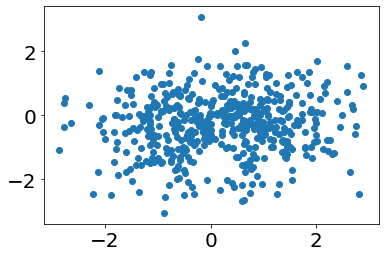

  8%|▊         | 801/10000 [00:54<13:52, 11.05it/s]

Current lr:  0.001
On batch number 800 ELBO is -16.313474655151367
On batch number 800 Best ELBO is -15.566057205200195


  9%|▉         | 899/10000 [01:00<10:00, 15.15it/s]

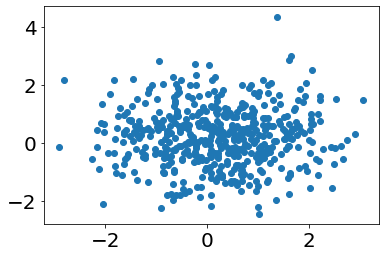

  9%|▉         | 901/10000 [01:00<12:55, 11.73it/s]

Current lr:  0.001
On batch number 900 ELBO is -16.879003524780273
On batch number 900 Best ELBO is -15.329315185546875


 10%|▉         | 999/10000 [01:07<09:50, 15.24it/s]

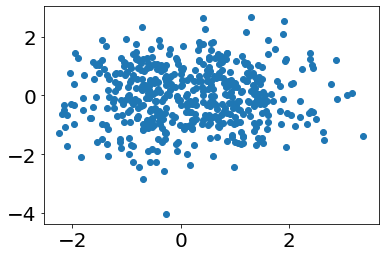

 10%|█         | 1003/10000 [01:07<11:54, 12.60it/s]

Current lr:  0.001
On batch number 1000 ELBO is -15.940096855163574
On batch number 1000 Best ELBO is -14.934985160827637


 11%|█         | 1099/10000 [01:14<09:46, 15.18it/s]

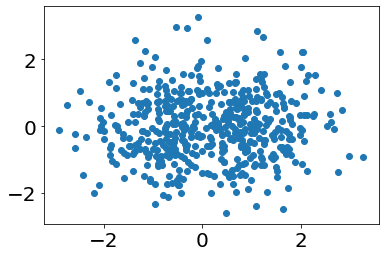

 11%|█         | 1103/10000 [01:14<11:50, 12.52it/s]

Current lr:  0.001
On batch number 1100 ELBO is -15.71064281463623
On batch number 1100 Best ELBO is -14.069195747375488


 12%|█▏        | 1199/10000 [01:20<09:40, 15.17it/s]

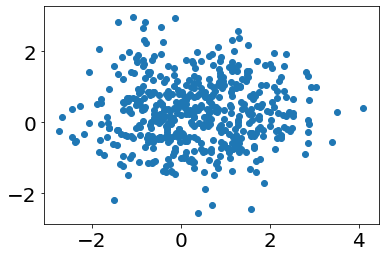

 12%|█▏        | 1203/10000 [01:21<12:21, 11.87it/s]

Current lr:  0.001
On batch number 1200 ELBO is -15.191189765930176
On batch number 1200 Best ELBO is -13.839119911193848


 13%|█▎        | 1299/10000 [01:27<09:28, 15.30it/s]

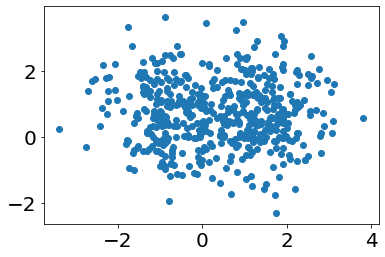

 13%|█▎        | 1301/10000 [01:27<12:40, 11.44it/s]

Current lr:  0.001
On batch number 1300 ELBO is -13.779499053955078
On batch number 1300 Best ELBO is -13.212496757507324


 14%|█▍        | 1399/10000 [01:34<09:30, 15.08it/s]

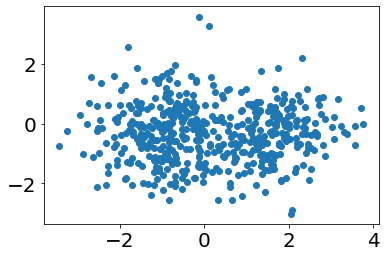

 14%|█▍        | 1403/10000 [01:34<11:30, 12.45it/s]

Current lr:  0.001
On batch number 1400 ELBO is -13.112615585327148
On batch number 1400 Best ELBO is -12.01822280883789


 15%|█▍        | 1499/10000 [01:40<09:18, 15.22it/s]

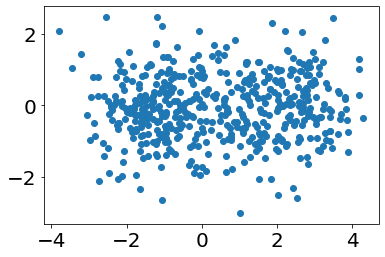

 15%|█▌        | 1501/10000 [01:41<12:59, 10.91it/s]

Current lr:  0.001
On batch number 1500 ELBO is -13.244471549987793
On batch number 1500 Best ELBO is -11.116571426391602


 16%|█▌        | 1599/10000 [01:47<09:12, 15.22it/s]

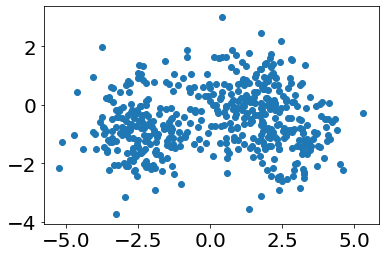

 16%|█▌        | 1601/10000 [01:48<12:02, 11.63it/s]

Current lr:  0.001
On batch number 1600 ELBO is -10.24453353881836
On batch number 1600 Best ELBO is -9.20632266998291


 17%|█▋        | 1699/10000 [01:54<09:05, 15.22it/s]

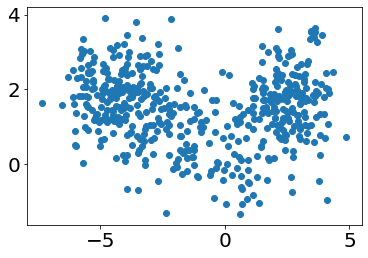

 17%|█▋        | 1701/10000 [01:54<11:48, 11.72it/s]

Current lr:  0.001
On batch number 1700 ELBO is -9.614900588989258
On batch number 1700 Best ELBO is -7.321256637573242


 18%|█▊        | 1799/10000 [02:01<08:58, 15.22it/s]

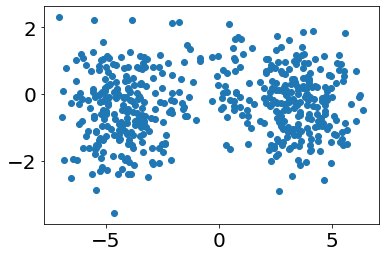

 18%|█▊        | 1801/10000 [02:01<11:40, 11.71it/s]

Current lr:  0.001
On batch number 1800 ELBO is -6.827541828155518
On batch number 1800 Best ELBO is -6.155229568481445


 19%|█▉        | 1899/10000 [02:07<08:52, 15.21it/s]

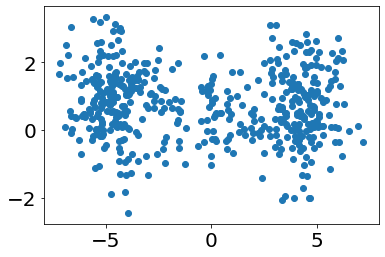

 19%|█▉        | 1901/10000 [02:08<12:26, 10.85it/s]

Current lr:  0.001
On batch number 1900 ELBO is -6.094681739807129
On batch number 1900 Best ELBO is -5.622045040130615


 20%|█▉        | 1999/10000 [02:14<08:45, 15.22it/s]

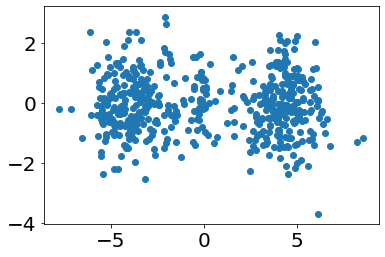

 20%|██        | 2003/10000 [02:14<10:35, 12.58it/s]

Current lr:  0.001
On batch number 2000 ELBO is -5.908660411834717
On batch number 2000 Best ELBO is -5.223385810852051


 21%|██        | 2099/10000 [02:21<08:38, 15.24it/s]

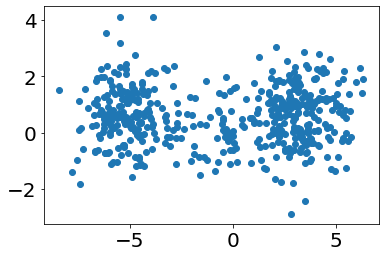

 21%|██        | 2103/10000 [02:21<10:27, 12.58it/s]

Current lr:  0.001
On batch number 2100 ELBO is -6.36991024017334
On batch number 2100 Best ELBO is -5.223385810852051


 22%|██▏       | 2199/10000 [02:28<08:32, 15.21it/s]

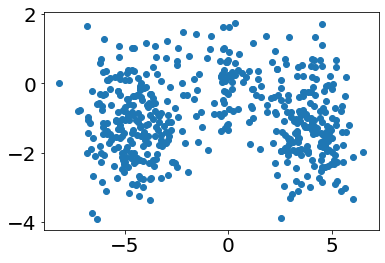

 22%|██▏       | 2203/10000 [02:28<10:22, 12.52it/s]

Current lr:  0.0009000000000000001
On batch number 2200 ELBO is -7.243271827697754
On batch number 2200 Best ELBO is -5.008916854858398


 23%|██▎       | 2299/10000 [02:34<08:33, 15.01it/s]

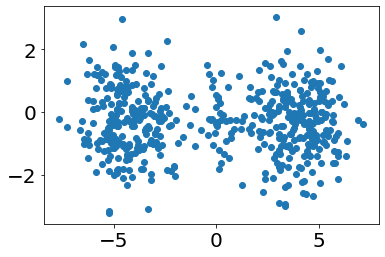

 23%|██▎       | 2301/10000 [02:35<11:53, 10.78it/s]

Current lr:  0.0009000000000000001
On batch number 2300 ELBO is -5.327371120452881
On batch number 2300 Best ELBO is -4.965389728546143


 24%|██▍       | 2399/10000 [02:41<08:26, 15.01it/s]

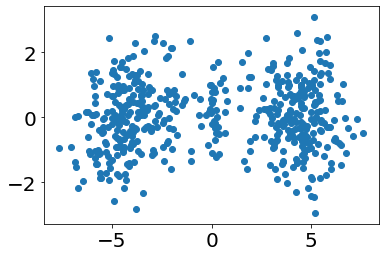

 24%|██▍       | 2403/10000 [02:41<10:10, 12.45it/s]

Current lr:  0.0009000000000000001
On batch number 2400 ELBO is -5.289951324462891
On batch number 2400 Best ELBO is -4.965389728546143


 25%|██▍       | 2499/10000 [02:48<08:19, 15.03it/s]

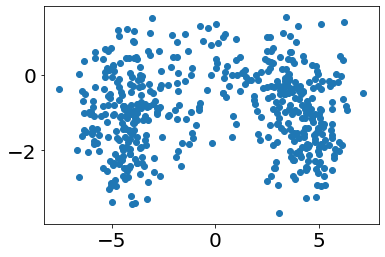

 25%|██▌       | 2501/10000 [02:48<10:44, 11.64it/s]

Current lr:  0.0008100000000000001
On batch number 2500 ELBO is -5.913527488708496
On batch number 2500 Best ELBO is -4.9383039474487305


 26%|██▌       | 2599/10000 [02:55<08:10, 15.09it/s]

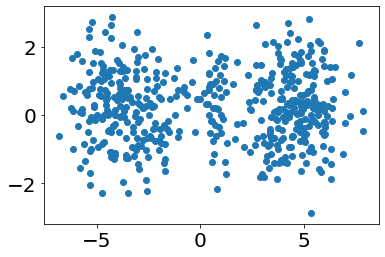

 26%|██▌       | 2601/10000 [02:55<11:15, 10.95it/s]

Current lr:  0.0008100000000000001
On batch number 2600 ELBO is -5.487447261810303
On batch number 2600 Best ELBO is -4.914346694946289


 27%|██▋       | 2699/10000 [03:01<07:55, 15.34it/s]

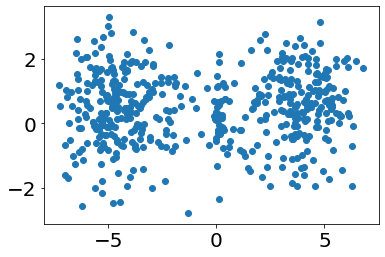

 27%|██▋       | 2701/10000 [03:02<10:15, 11.85it/s]

Current lr:  0.0008100000000000001
On batch number 2700 ELBO is -5.442105770111084
On batch number 2700 Best ELBO is -4.679600715637207


 28%|██▊       | 2799/10000 [03:08<07:50, 15.31it/s]

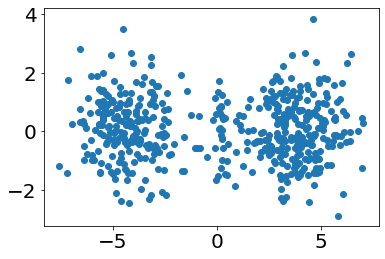

 28%|██▊       | 2801/10000 [03:08<10:10, 11.79it/s]

Current lr:  0.0008100000000000001
On batch number 2800 ELBO is -4.84425687789917
On batch number 2800 Best ELBO is -4.625457286834717


 29%|██▉       | 2899/10000 [03:15<07:47, 15.20it/s]

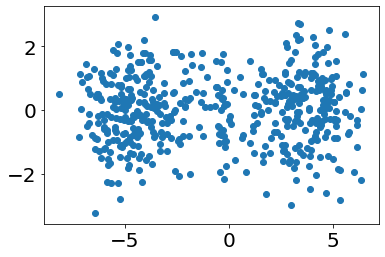

 29%|██▉       | 2901/10000 [03:15<10:22, 11.41it/s]

Current lr:  0.0008100000000000001
On batch number 2900 ELBO is -5.6493940353393555
On batch number 2900 Best ELBO is -4.625457286834717


 30%|██▉       | 2999/10000 [03:21<07:35, 15.38it/s]

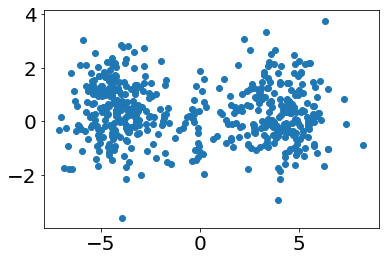

 30%|███       | 3003/10000 [03:22<09:45, 11.94it/s]

Current lr:  0.000729
On batch number 3000 ELBO is -4.731603622436523
On batch number 3000 Best ELBO is -4.625457286834717


 31%|███       | 3099/10000 [03:28<07:34, 15.17it/s]

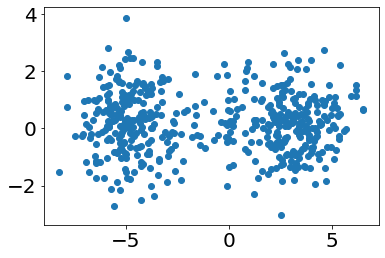

 31%|███       | 3103/10000 [03:29<09:11, 12.50it/s]

Current lr:  0.000729
On batch number 3100 ELBO is -5.979646682739258
On batch number 3100 Best ELBO is -4.574286937713623


 32%|███▏      | 3199/10000 [03:35<07:28, 15.17it/s]

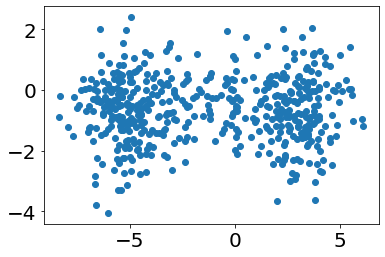

 32%|███▏      | 3203/10000 [03:35<09:02, 12.53it/s]

Current lr:  0.000729
On batch number 3200 ELBO is -5.569167137145996
On batch number 3200 Best ELBO is -4.574286937713623


 33%|███▎      | 3299/10000 [03:42<07:23, 15.10it/s]

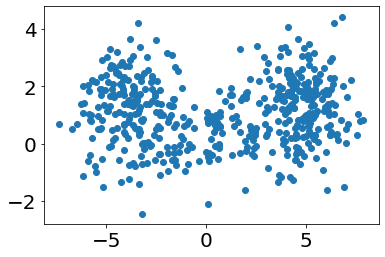

 33%|███▎      | 3301/10000 [03:42<09:34, 11.65it/s]

Current lr:  0.0006561000000000001
On batch number 3300 ELBO is -5.765831470489502
On batch number 3300 Best ELBO is -4.480733871459961


 34%|███▍      | 3399/10000 [03:48<07:14, 15.18it/s]

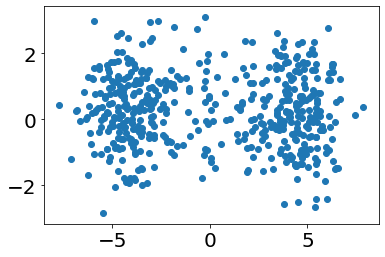

 34%|███▍      | 3403/10000 [03:49<09:16, 11.86it/s]

Current lr:  0.0006561000000000001
On batch number 3400 ELBO is -5.535257816314697
On batch number 3400 Best ELBO is -4.480733871459961


 35%|███▍      | 3499/10000 [03:55<07:06, 15.24it/s]

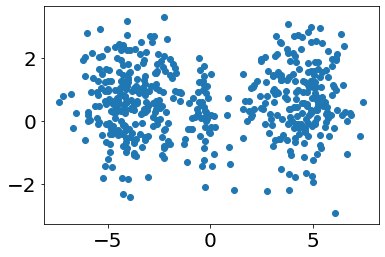

 35%|███▌      | 3503/10000 [03:56<08:49, 12.28it/s]

Current lr:  0.00059049
On batch number 3500 ELBO is -5.130337715148926
On batch number 3500 Best ELBO is -4.480733871459961


 36%|███▌      | 3599/10000 [04:02<07:04, 15.06it/s]

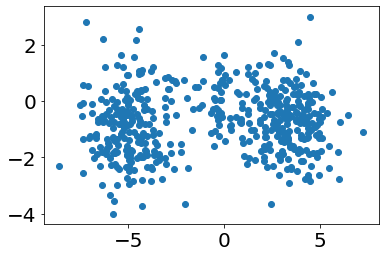

 36%|███▌      | 3601/10000 [04:02<09:11, 11.61it/s]

Current lr:  0.00059049
On batch number 3600 ELBO is -5.70056676864624
On batch number 3600 Best ELBO is -4.394083023071289


 37%|███▋      | 3699/10000 [04:09<07:00, 14.97it/s]

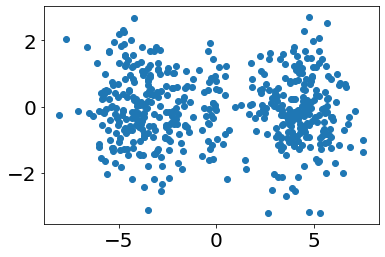

 37%|███▋      | 3701/10000 [04:09<09:53, 10.61it/s]

Current lr:  0.00059049
On batch number 3700 ELBO is -4.552547931671143
On batch number 3700 Best ELBO is -4.3749589920043945


 38%|███▊      | 3799/10000 [04:15<06:49, 15.13it/s]

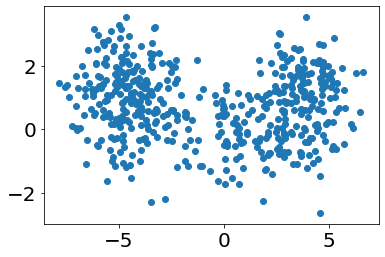

 38%|███▊      | 3803/10000 [04:16<08:15, 12.51it/s]

Current lr:  0.00059049
On batch number 3800 ELBO is -5.3832221031188965
On batch number 3800 Best ELBO is -4.3749589920043945


 39%|███▉      | 3899/10000 [04:22<06:47, 14.96it/s]

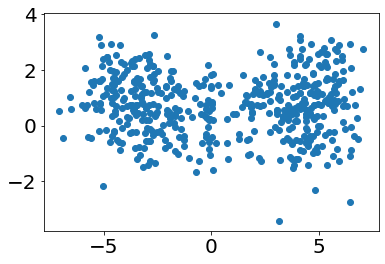

 39%|███▉      | 3901/10000 [04:23<08:46, 11.58it/s]

Current lr:  0.000531441
On batch number 3900 ELBO is -5.427511215209961
On batch number 3900 Best ELBO is -4.3749589920043945


 40%|███▉      | 3999/10000 [04:29<06:37, 15.11it/s]

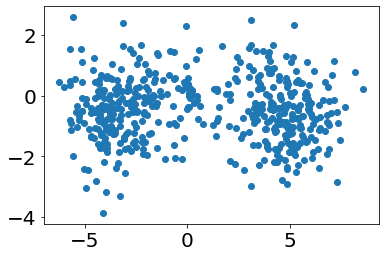

 40%|████      | 4001/10000 [04:29<08:34, 11.65it/s]

Current lr:  0.000531441
On batch number 4000 ELBO is -5.168892860412598
On batch number 4000 Best ELBO is -4.3749589920043945


 41%|████      | 4099/10000 [04:36<06:17, 15.63it/s]

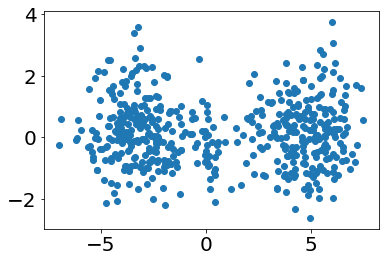

 41%|████      | 4103/10000 [04:36<08:06, 12.13it/s]

Current lr:  0.0004782969
On batch number 4100 ELBO is -4.989202499389648
On batch number 4100 Best ELBO is -4.3749589920043945


 42%|████▏     | 4199/10000 [04:42<06:18, 15.31it/s]

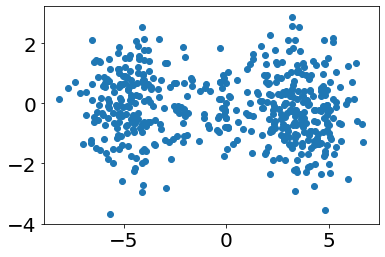

 42%|████▏     | 4201/10000 [04:43<08:13, 11.75it/s]

Current lr:  0.0004782969
On batch number 4200 ELBO is -4.855624675750732
On batch number 4200 Best ELBO is -4.3749589920043945


 43%|████▎     | 4299/10000 [04:49<06:16, 15.13it/s]

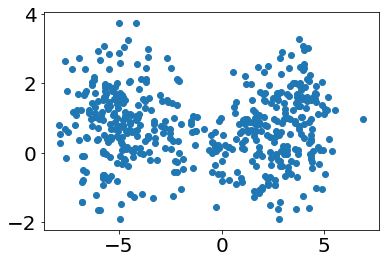

 43%|████▎     | 4301/10000 [04:49<08:08, 11.66it/s]

Current lr:  0.00043046721
On batch number 4300 ELBO is -5.875152587890625
On batch number 4300 Best ELBO is -4.3749589920043945


 44%|████▍     | 4399/10000 [04:56<06:07, 15.23it/s]

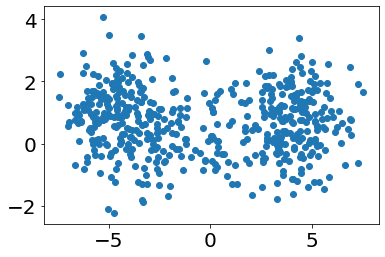

 44%|████▍     | 4403/10000 [04:56<07:25, 12.56it/s]

Current lr:  0.00043046721
On batch number 4400 ELBO is -4.986423015594482
On batch number 4400 Best ELBO is -4.2874436378479


 45%|████▍     | 4499/10000 [05:02<06:02, 15.17it/s]

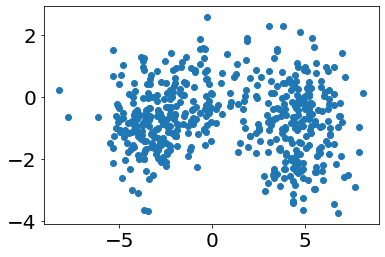

 45%|████▌     | 4501/10000 [05:03<08:24, 10.89it/s]

Current lr:  0.00043046721
On batch number 4500 ELBO is -5.859413146972656
On batch number 4500 Best ELBO is -4.2874436378479


 46%|████▌     | 4599/10000 [05:09<05:55, 15.18it/s]

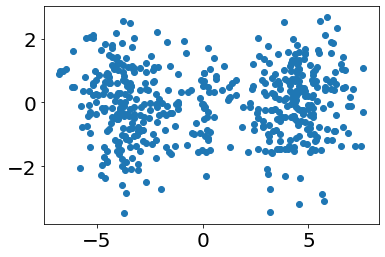

 46%|████▌     | 4601/10000 [05:09<07:40, 11.73it/s]

Current lr:  0.000387420489
On batch number 4600 ELBO is -4.904722690582275
On batch number 4600 Best ELBO is -4.2874436378479


 47%|████▋     | 4699/10000 [05:16<05:49, 15.16it/s]

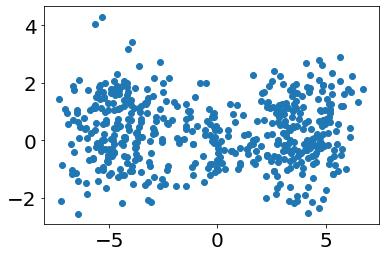

 47%|████▋     | 4703/10000 [05:16<07:04, 12.49it/s]

Current lr:  0.000387420489
On batch number 4700 ELBO is -5.197617530822754
On batch number 4700 Best ELBO is -4.2874436378479


 48%|████▊     | 4799/10000 [05:23<05:45, 15.06it/s]

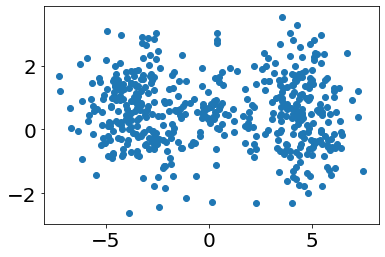

 48%|████▊     | 4801/10000 [05:23<07:55, 10.92it/s]

Current lr:  0.0003486784401
On batch number 4800 ELBO is -5.710939407348633
On batch number 4800 Best ELBO is -4.2874436378479


 49%|████▉     | 4899/10000 [05:29<05:35, 15.19it/s]

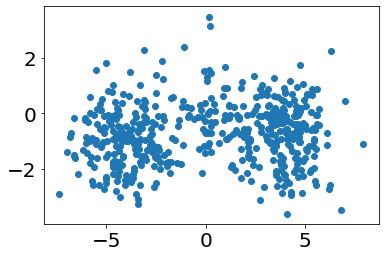

 49%|████▉     | 4901/10000 [05:30<07:14, 11.74it/s]

Current lr:  0.0003486784401
On batch number 4900 ELBO is -5.165665149688721
On batch number 4900 Best ELBO is -4.2874436378479


 50%|████▉     | 4999/10000 [05:36<05:25, 15.36it/s]

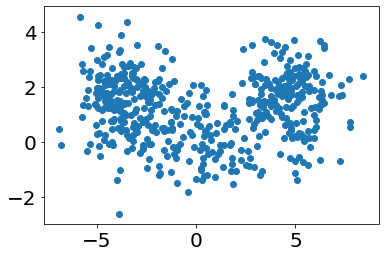

 50%|█████     | 5001/10000 [05:36<07:02, 11.84it/s]

Current lr:  0.00031381059609000004
On batch number 5000 ELBO is -6.298494338989258
On batch number 5000 Best ELBO is -4.1533284187316895


 51%|█████     | 5099/10000 [05:43<05:18, 15.39it/s]

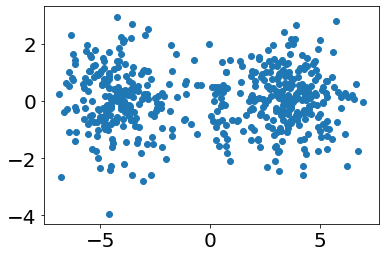

 51%|█████     | 5101/10000 [05:43<07:06, 11.47it/s]

Current lr:  0.00031381059609000004
On batch number 5100 ELBO is -5.155430793762207
On batch number 5100 Best ELBO is -4.1533284187316895


 52%|█████▏    | 5199/10000 [05:49<05:10, 15.44it/s]

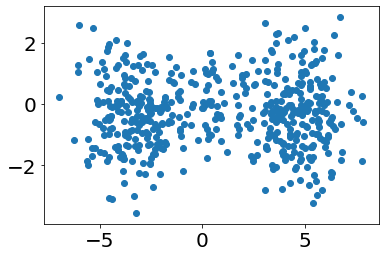

 52%|█████▏    | 5203/10000 [05:50<06:38, 12.04it/s]

Current lr:  0.00028242953648100003
On batch number 5200 ELBO is -5.280257225036621
On batch number 5200 Best ELBO is -4.1533284187316895


 53%|█████▎    | 5299/10000 [05:56<05:06, 15.34it/s]

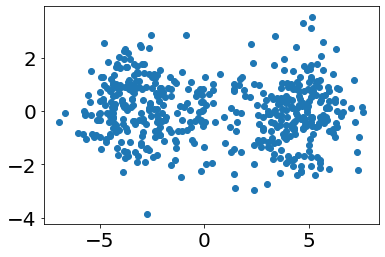

 53%|█████▎    | 5301/10000 [05:56<06:50, 11.44it/s]

Current lr:  0.00028242953648100003
On batch number 5300 ELBO is -4.953622341156006
On batch number 5300 Best ELBO is -4.1533284187316895


 54%|█████▍    | 5399/10000 [06:03<05:03, 15.17it/s]

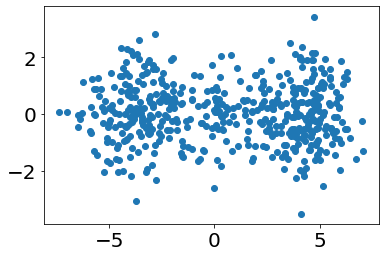

 54%|█████▍    | 5401/10000 [06:03<06:32, 11.71it/s]

Current lr:  0.00025418658283290005
On batch number 5400 ELBO is -5.791424751281738
On batch number 5400 Best ELBO is -4.1533284187316895


 55%|█████▍    | 5499/10000 [06:09<04:56, 15.17it/s]

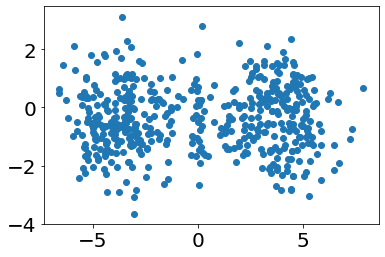

 55%|█████▌    | 5501/10000 [06:10<06:25, 11.68it/s]

Current lr:  0.00025418658283290005
On batch number 5500 ELBO is -4.926592826843262
On batch number 5500 Best ELBO is -4.1533284187316895


 56%|█████▌    | 5599/10000 [06:16<04:50, 15.15it/s]

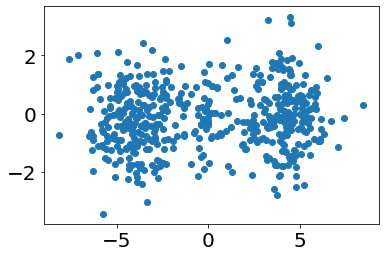

 56%|█████▌    | 5603/10000 [06:17<06:12, 11.82it/s]

Current lr:  0.00022876792454961005
On batch number 5600 ELBO is -4.907140731811523
On batch number 5600 Best ELBO is -4.1533284187316895


 57%|█████▋    | 5699/10000 [06:23<04:43, 15.17it/s]

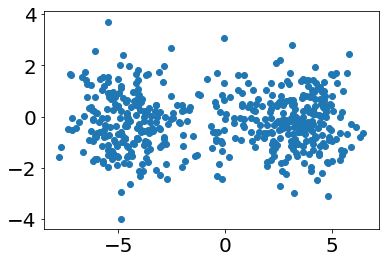

 57%|█████▋    | 5703/10000 [06:23<05:43, 12.49it/s]

Current lr:  0.00022876792454961005
On batch number 5700 ELBO is -4.9729838371276855
On batch number 5700 Best ELBO is -4.1533284187316895


 58%|█████▊    | 5799/10000 [06:30<04:36, 15.17it/s]

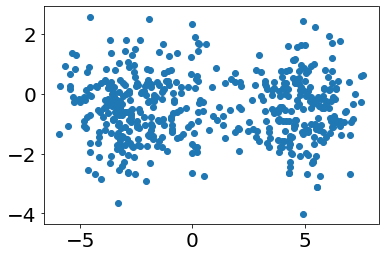

 58%|█████▊    | 5801/10000 [06:30<05:58, 11.70it/s]

Current lr:  0.00020589113209464906
On batch number 5800 ELBO is -5.322945594787598
On batch number 5800 Best ELBO is -4.1533284187316895


 59%|█████▉    | 5899/10000 [06:36<04:31, 15.11it/s]

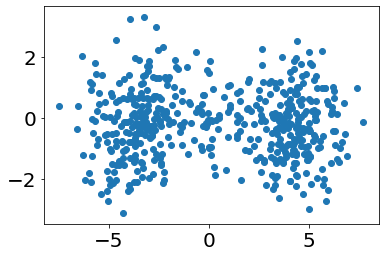

 59%|█████▉    | 5901/10000 [06:37<06:17, 10.86it/s]

Current lr:  0.00020589113209464906
On batch number 5900 ELBO is -4.765779495239258
On batch number 5900 Best ELBO is -4.1533284187316895


 60%|█████▉    | 5999/10000 [06:43<04:24, 15.10it/s]

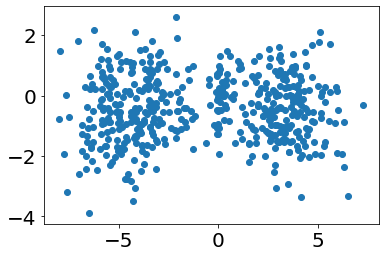

 60%|██████    | 6001/10000 [06:44<05:43, 11.65it/s]

Current lr:  0.00018530201888518417
On batch number 6000 ELBO is -4.927321434020996
On batch number 6000 Best ELBO is -4.1533284187316895


 61%|██████    | 6099/10000 [06:50<04:18, 15.09it/s]

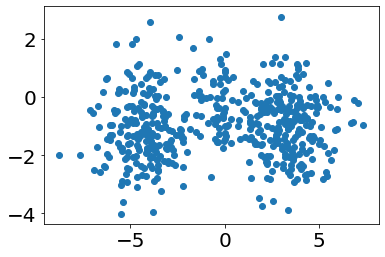

 61%|██████    | 6103/10000 [06:50<05:12, 12.46it/s]

Current lr:  0.00018530201888518417
On batch number 6100 ELBO is -5.882646560668945
On batch number 6100 Best ELBO is -4.1533284187316895


 62%|██████▏   | 6199/10000 [06:57<04:10, 15.17it/s]

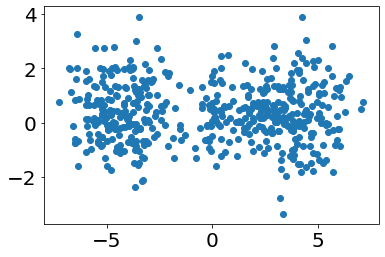

 62%|██████▏   | 6203/10000 [06:57<05:03, 12.51it/s]

Current lr:  0.00016677181699666576
On batch number 6200 ELBO is -5.179687976837158
On batch number 6200 Best ELBO is -4.1533284187316895


 63%|██████▎   | 6299/10000 [07:03<04:03, 15.17it/s]

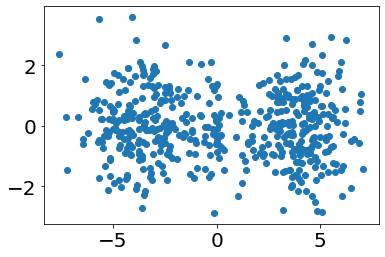

 63%|██████▎   | 6301/10000 [07:04<05:41, 10.85it/s]

Current lr:  0.00016677181699666576
On batch number 6300 ELBO is -5.052863597869873
On batch number 6300 Best ELBO is -4.1533284187316895


 64%|██████▍   | 6399/10000 [07:10<03:57, 15.18it/s]

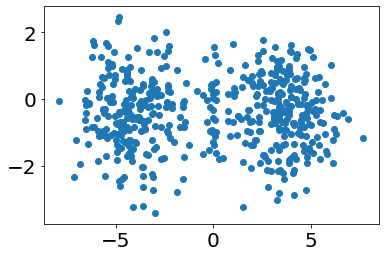

 64%|██████▍   | 6403/10000 [07:11<04:46, 12.56it/s]

Current lr:  0.0001500946352969992
On batch number 6400 ELBO is -5.786899089813232
On batch number 6400 Best ELBO is -4.1533284187316895


 65%|██████▍   | 6499/10000 [07:17<03:47, 15.38it/s]

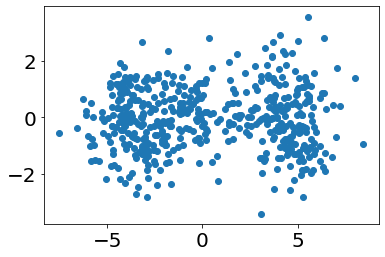

 65%|██████▌   | 6501/10000 [07:17<04:53, 11.91it/s]

Current lr:  0.0001500946352969992
On batch number 6500 ELBO is -5.115165710449219
On batch number 6500 Best ELBO is -4.1533284187316895


 66%|██████▌   | 6599/10000 [07:24<03:40, 15.46it/s]

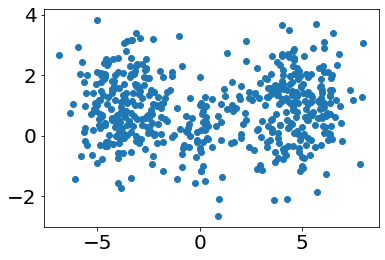

 66%|██████▌   | 6601/10000 [07:24<04:47, 11.84it/s]

Current lr:  0.0001350851717672993
On batch number 6600 ELBO is -5.0978312492370605
On batch number 6600 Best ELBO is -4.144973278045654


 67%|██████▋   | 6699/10000 [07:30<03:35, 15.30it/s]

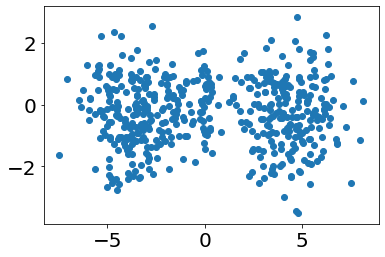

 67%|██████▋   | 6703/10000 [07:31<04:36, 11.92it/s]

Current lr:  0.0001350851717672993
On batch number 6700 ELBO is -4.651843547821045
On batch number 6700 Best ELBO is -4.144973278045654


 68%|██████▊   | 6799/10000 [07:37<03:28, 15.33it/s]

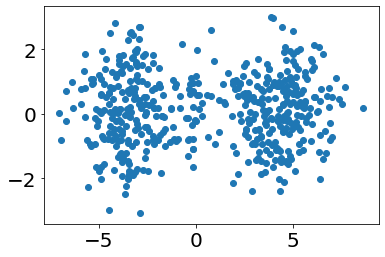

 68%|██████▊   | 6803/10000 [07:37<04:11, 12.69it/s]

Current lr:  0.00012157665459056936
On batch number 6800 ELBO is -4.818536281585693
On batch number 6800 Best ELBO is -4.144973278045654


 69%|██████▉   | 6899/10000 [07:44<03:22, 15.32it/s]

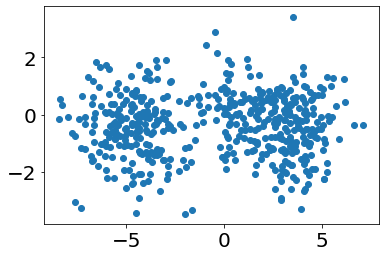

 69%|██████▉   | 6901/10000 [07:44<04:21, 11.83it/s]

Current lr:  0.00012157665459056936
On batch number 6900 ELBO is -5.072051048278809
On batch number 6900 Best ELBO is -4.144973278045654


 70%|██████▉   | 6999/10000 [07:50<03:14, 15.45it/s]

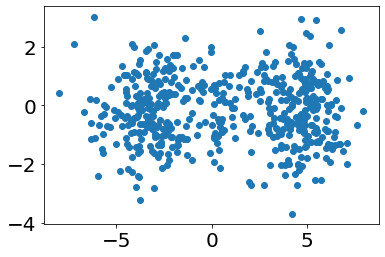

 70%|███████   | 7003/10000 [07:51<04:09, 12.02it/s]

Current lr:  0.00010941898913151243
On batch number 7000 ELBO is -5.009431838989258
On batch number 7000 Best ELBO is -4.144973278045654


 71%|███████   | 7099/10000 [07:57<03:09, 15.30it/s]

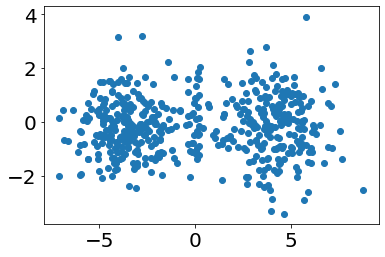

 71%|███████   | 7103/10000 [07:57<03:49, 12.63it/s]

Current lr:  0.00010941898913151243
On batch number 7100 ELBO is -4.768023490905762
On batch number 7100 Best ELBO is -4.144973278045654


 72%|███████▏  | 7199/10000 [08:04<03:03, 15.29it/s]

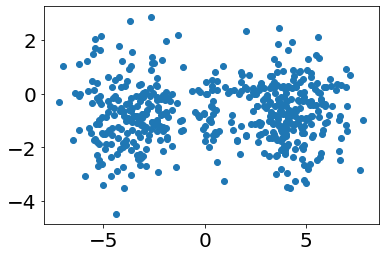

 72%|███████▏  | 7203/10000 [08:04<03:41, 12.64it/s]

Current lr:  9.847709021836118e-05
On batch number 7200 ELBO is -4.886655330657959
On batch number 7200 Best ELBO is -4.144973278045654


 73%|███████▎  | 7299/10000 [08:10<02:57, 15.23it/s]

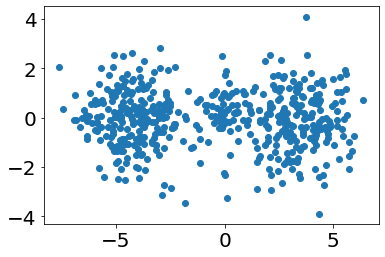

 73%|███████▎  | 7301/10000 [08:11<03:50, 11.69it/s]

Current lr:  9.847709021836118e-05
On batch number 7300 ELBO is -5.036285400390625
On batch number 7300 Best ELBO is -4.144973278045654


 74%|███████▍  | 7399/10000 [08:17<02:51, 15.17it/s]

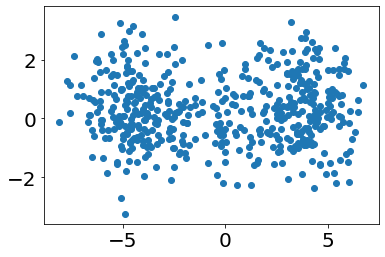

 74%|███████▍  | 7403/10000 [08:17<03:38, 11.87it/s]

Current lr:  8.862938119652506e-05
On batch number 7400 ELBO is -4.478575706481934
On batch number 7400 Best ELBO is -4.144973278045654


 75%|███████▍  | 7499/10000 [08:24<02:44, 15.23it/s]

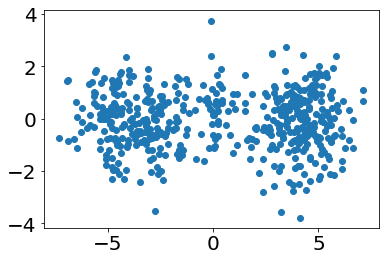

 75%|███████▌  | 7503/10000 [08:24<03:18, 12.55it/s]

Current lr:  8.862938119652506e-05
On batch number 7500 ELBO is -4.874881267547607
On batch number 7500 Best ELBO is -4.144973278045654


 76%|███████▌  | 7599/10000 [08:30<02:36, 15.31it/s]

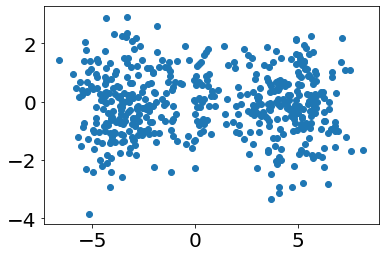

 76%|███████▌  | 7603/10000 [08:31<03:09, 12.62it/s]

Current lr:  7.976644307687256e-05
On batch number 7600 ELBO is -5.471731185913086
On batch number 7600 Best ELBO is -4.144973278045654


 77%|███████▋  | 7699/10000 [08:37<02:30, 15.32it/s]

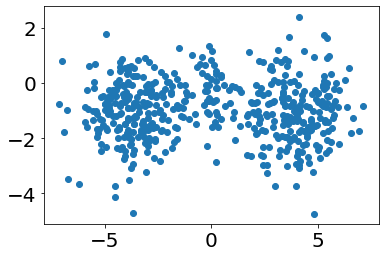

 77%|███████▋  | 7703/10000 [08:37<03:01, 12.64it/s]

Current lr:  7.976644307687256e-05
On batch number 7700 ELBO is -5.868878364562988
On batch number 7700 Best ELBO is -4.144973278045654


 78%|███████▊  | 7799/10000 [08:44<02:23, 15.31it/s]

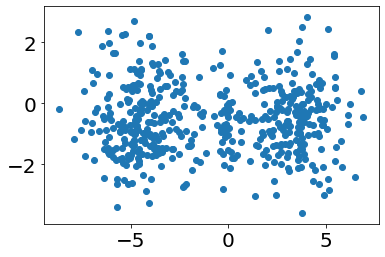

 78%|███████▊  | 7803/10000 [08:44<03:04, 11.94it/s]

Current lr:  7.17897987691853e-05
On batch number 7800 ELBO is -5.225632190704346
On batch number 7800 Best ELBO is -4.144973278045654


 79%|███████▉  | 7899/10000 [08:50<02:17, 15.24it/s]

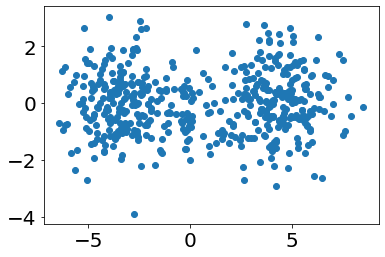

 79%|███████▉  | 7901/10000 [08:51<02:58, 11.74it/s]

Current lr:  7.17897987691853e-05
On batch number 7900 ELBO is -5.2464141845703125
On batch number 7900 Best ELBO is -4.144973278045654


 80%|███████▉  | 7999/10000 [08:57<02:11, 15.23it/s]

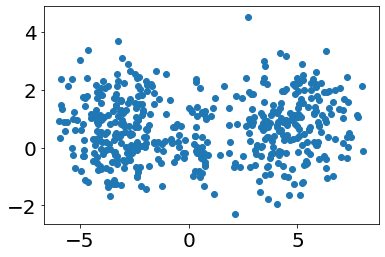

 80%|████████  | 8001/10000 [08:57<02:50, 11.72it/s]

Current lr:  6.461081889226677e-05
On batch number 8000 ELBO is -5.352388858795166
On batch number 8000 Best ELBO is -4.144973278045654


 81%|████████  | 8099/10000 [09:04<02:05, 15.16it/s]

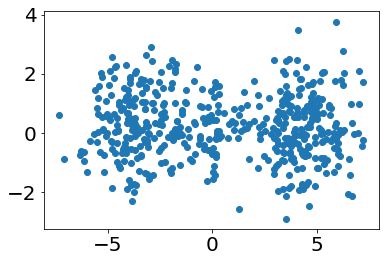

 81%|████████  | 8101/10000 [09:04<02:53, 10.94it/s]

Current lr:  6.461081889226677e-05
On batch number 8100 ELBO is -4.948665618896484
On batch number 8100 Best ELBO is -4.144973278045654


 82%|████████▏ | 8199/10000 [09:11<01:59, 15.12it/s]

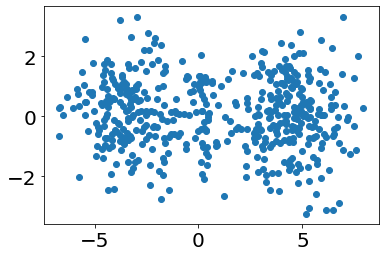

 82%|████████▏ | 8201/10000 [09:11<02:34, 11.68it/s]

Current lr:  5.81497370030401e-05
On batch number 8200 ELBO is -5.176696300506592
On batch number 8200 Best ELBO is -4.144973278045654


 83%|████████▎ | 8299/10000 [09:17<01:51, 15.31it/s]

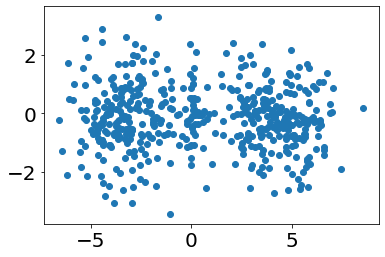

 83%|████████▎ | 8303/10000 [09:18<02:17, 12.31it/s]

Current lr:  5.81497370030401e-05
On batch number 8300 ELBO is -6.23378324508667
On batch number 8300 Best ELBO is -4.144973278045654


 84%|████████▍ | 8399/10000 [09:24<01:44, 15.30it/s]

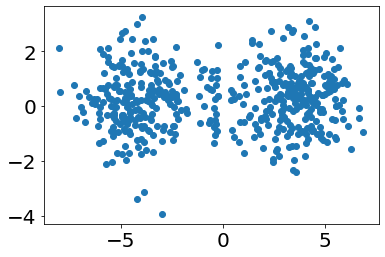

 84%|████████▍ | 8401/10000 [09:24<02:15, 11.77it/s]

Current lr:  5.233476330273609e-05
On batch number 8400 ELBO is -5.406270503997803
On batch number 8400 Best ELBO is -4.144973278045654


 85%|████████▍ | 8499/10000 [09:31<01:38, 15.30it/s]

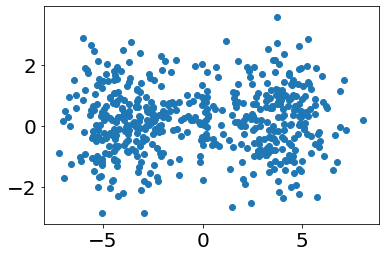

 85%|████████▌ | 8503/10000 [09:31<02:05, 11.90it/s]

Current lr:  5.233476330273609e-05
On batch number 8500 ELBO is -5.452617645263672
On batch number 8500 Best ELBO is -4.144973278045654


 86%|████████▌ | 8589/10000 [09:37<01:34, 14.88it/s]

Early stopping on 8590


In [11]:
print_info_ = 100
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)
best_elbo = -float("inf")

x_lim = limit
y_lim = limit

def compute_loss(q_new, p_new, q_old, p_old, sum_log_alpha, sum_log_jac, all_directions=None):
#     pdb.set_trace()
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=q_new, a=all_directions)
    else:
        log_r = -args.K * torch_log_2
    log_p = target.get_logdensity(z=q_new) + args.std_normal.log_prob(p_new).sum(1)
    log_m = args.std_normal.log_prob(q_old).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac + sum_log_alpha
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full.detach().mean().item(), grad_elbo


iterator = tqdm(range(args.num_batches))
cur_tolerance = 0
for batch_num in iterator:
    plt.close()
    cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]
        
    # sample initial q and p
    q_old = args.std_normal.sample((args.train_batch_size, args.z_dim)).requires_grad_(True)
    p_old = args.std_normal.sample((args.train_batch_size, args.z_dim))
    
    # prepare tensors for auxilary stuff
    sum_log_alpha = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
    sum_log_jacobian = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
    
    q = q_old
    p = p_old
    if (batch_num) % print_info_ == 0:
        array_z = []
        array_directions = []
        array_alpha = []
        array_prop = []
        
    if args.learnable_reverse:
        all_directions = torch.tensor([], device=args.device)
    else:
        all_directions = None
        
    # run training cycle
    for k in range(args.K):
        q, p, log_jac, current_log_alphas, directions, q_prop = transitions[k].make_transition(q_old=q,
                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
#         if (batch_num) % print_info_ == 0:
#             print('On batch number {} and on k = {} we have for 0: {} and for +1: {}'.format(batch_num, k + 1,
#                                                         (directions==0.).to(float).mean(), (directions==1.).to(float).mean()))
#             print('Step size for {}-th transition is {}'.format(k, transitions[k].gamma.detach().exp()))
#             print('Alpha (ref) for {}-th transition is {}'.format(k, torch.sigmoid(transitions[k].alpha_logit.detach())))
        sum_log_alpha = sum_log_alpha + current_log_alphas
        sum_log_jacobian = sum_log_jacobian + log_jac
        if (batch_num) % print_info_ == 0:
            array_z.append(q.detach())
            array_directions.append(directions.detach())
            array_alpha.append(current_log_alphas.detach())
            array_prop.append(q_prop.detach())
        if args.learnable_reverse:
            all_directions = torch.cat([all_directions, directions.detach().view(-1, 1)], dim=1)
    elbo_full, grad_elbo = compute_loss(q_new=q, p_new=p, q_old=q_old, p_old=p_old, sum_log_jac=sum_log_jacobian,
                                            sum_log_alpha=sum_log_alpha, all_directions=all_directions)
    if (batch_num ) % print_info_ == 0:
        plt.scatter(q.cpu().detach()[:, 0], q.cpu().detach()[:, 1])
        plt.show();
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        print('Current lr: ', current_lr)
        print('On batch number {} ELBO is {}'.format(batch_num, elbo_full))
        print('On batch number {} Best ELBO is {}'.format(batch_num, best_elbo))
        
        fig, ax = plt.subplots(ncols=args.K, figsize=(30, 10))
        label = ['Same', 'Forward']
#         for kk in range(args.K):
#             ax[kk].scatter(array_prop[kk][:, 0].cpu().numpy(), array_prop[kk][:, 1].cpu().numpy(), color='r', label='Proposals')
#             for d in [0., 1.]:
#                 z_c = array_z[kk][array_directions[kk]==d]
#                 alpha_c = array_alpha[kk][array_directions[kk]==d].cpu().exp().numpy()
#                 color = np.zeros((z_c.shape[0], 4))
#                 color[:, 3] = alpha_c
#                 color[:, int(d + 1)] = 1.
#                 ax[kk].scatter(z_c[:, 0].cpu().numpy(), z_c[:, 1].cpu().numpy(), color=color, label=label[int(d)])
# #                 ax[kk].set_xlim((-x_lim, x_lim))
# #                 ax[kk].set_ylim((-y_lim, y_lim))
#                 ax[kk].legend()
#         plt.show();
    (-grad_elbo).backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(elbo_full)

    if np.isnan(elbo_full):
        print('NAN appeared!')
        iterator.close()
        raise ValueError

    if elbo_full > best_elbo:
        best_elbo = elbo_full
        our_kernel.load_state_dict(transitions.state_dict())
        cur_tolerance = 0
    else:
        cur_tolerance += 1
        if cur_tolerance >= args.early_stopping_tolerance:
            print('Early stopping on {}'.format(batch_num))
            iterator.close()
            break

In [12]:
# our_kernel = transitions
for p in our_kernel.parameters():
    p.requires_grad_(False)

In [21]:
# q_new = q_init
# p_new = p_init

# print("Now we are running warmup!")
# iterator = tqdm(range(args.n_warmup // args.K))
# for i in iterator:
#     q_new = q_new.detach().requires_grad_(True)
#     p_new = p_new.detach().requires_grad_(True)
#     for k in range(args.K):
#         cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
#         q_new, p_new, _, _, _, _ = our_kernel[k].make_transition(q_old=q_new, p_old=p_new, target_distr=target,
#                                                                    k=cond_vectors[k])
# iterator.close()
    
# samples_our = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)
# print("Now we are sampling!")

# iterator = tqdm(range(args.n_steps // args.K))
# for i in iterator:
#     q_new = q_new.detach().requires_grad_(True)
#     p_new = p_new.detach().requires_grad_(True)
#     for k in range(args.K):
#         cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
#         q_new, p_new, _, _, a, _ = our_kernel[k].make_transition(q_old=q_new, p_old=p_new, target_distr=target,
#                                                                        k=cond_vectors[k])
#         samples_our[i] = q_new.detach()
# iterator.close()

In [22]:
# target_samples = target.get_samples(n=1000).cpu().numpy()

# fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
# plt.suptitle('HMC our')
# for chain_num in range(args.n_chains):
#     ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
#     ax[chain_num // 5, chain_num % 5].scatter(samples_our[:, chain_num, 0].cpu(), samples_our[:, chain_num, 1].cpu(), label='Result')
#     ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
#     ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
#     ax[chain_num // 5, chain_num % 5].set_aspect('equal')
#     ax[chain_num // 5, chain_num % 5].legend()
# plt.tight_layout();
# plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

In [15]:
# n_samples = 10000
n_chains = 50
repetitions = 500

init_q = args.std_normal.sample((n_chains, args.z_dim)).requires_grad_(True)
q = init_q
our_samples = []
our_samples.append(q.cpu().detach().numpy())

# init_p = args.std_normal.sample((n_samples, args.z_dim))
# p = init_p

for rep in range(repetitions):
    init_p = args.std_normal.sample((n_chains, args.z_dim))
    p = init_p
    cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
    for k in range(args.K):
        q, p, _, _, _, _ = our_kernel[k].make_transition(q_old=q,
                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
        our_samples.append(q.cpu().detach().numpy())

In [16]:
our_samples = np.array(our_samples)

In [17]:
our_samples.shape

(5001, 50, 2)

In [18]:
target_samples = target.get_samples(our_samples[:, 0, :].shape[0])

In [19]:
target_samples.shape

torch.Size([5001, 2])

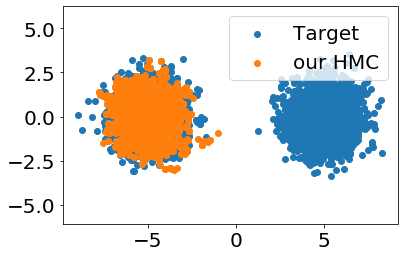

In [20]:
chain_ind = 10


plt.scatter(target_samples[:, 0].cpu().detach().numpy(), target_samples[:, 1].cpu().detach().numpy(), label='Target')
plt.scatter(our_samples[:, chain_ind, 0], our_samples[:, chain_ind, 1], label='our HMC')
# plt.xlim((-4, 4))
# plt.ylim((-4, 4))
plt.axis('equal')
plt.legend();